In [47]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev
from tqdm.contrib.telegram import tqdm, trange
from dotenv import load_dotenv
import os

from bob_telegram_tools.bot import TelegramBot
load_dotenv()
import pyreadr
import numpy as np
import pickle
import pandas as pd
import statsmodels.api as sm

In [48]:
# # without migrants
# non_migration = {name:np.array(pyreadr.read_r(f"{name}_non_migration.Rda")[f"{name}_nm"]) 
#                  for name in ["N_female", "N_male"]}
# demography_in_model = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
#  for t,row in enumerate(non_migration['N_female'])])
# Pi = (demography_in_model/demography_in_model.max(axis=0))
# Pi_female = Pi[:,(96-65):-20].transpose()
# demography_in_model = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
#  for t,row in enumerate(non_migration['N_male'])])
# Pi = (demography_in_model/demography_in_model.max(axis=0))
# Pi_male = Pi[:,(96-65):-20].transpose()
# Pi = np.array([Pi_female, Pi_male])
# with_migration = {name:np.array(pyreadr.read_r(f"{name}.Rda")[f"{name}"]) 
#                  for name in ["N_female", "N_male"]}
# N_female = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
#  for t,row in enumerate(with_migration['N_female'])])[:,(96-65):-20].transpose()
# N_male = np.array([[val if (111-g+t <=80) and (111-g+t>20) else 0 for g, val in enumerate(row)]
#  for t,row in enumerate(with_migration['N_male'])])[:,(96-65):-20].transpose()
# N = np.array([N_female, N_male])


In [49]:
# df_wage = pd.read_excel("rosstat/wage_by_cohort.xlsx")
# df_wage_ext = pd.DataFrame([(1,(i-20),(i-20)**2,df_wage['wage'][df_wage['age']<=i].iloc[-1])
#                             for i in range(20,81)], columns = ['intercept','age','agesq','wage'])
# df_wage_ext['wage']=np.log(df_wage_ext['wage']/max(df_wage_ext['wage']))
# model = sm.OLS(df_wage_ext['wage'], df_wage_ext[['intercept','age','agesq']]).fit()

In [50]:
# n_generations=60
# epsilon_female =epsilon_male= np.array([[np.exp(model.params[2]*(n_generations-g+t)**2+
#                                                 model.params[1]*(n_generations-g+t)+
#                                                model.params[0])\
#                                          if ((n_generations-g+t) > 0 and (n_generations-g+t)<=n_generations) \
#                                          else 0  for t in range(N_female.shape[1]) ] \
#                                         for g in range(N_female.shape[0])])
# epsilon = np.array([epsilon_female, epsilon_male])

# rho_female = np.array([[1 if ((n_generations-g+t) >= 51 and (n_generations-g+t)<=n_generations) else 0
#                         for t in range(N_female.shape[1]) ] 
#                        for g in range(N_female.shape[0])])
# rho_male = np.array([[1 if ((n_generations-g+t) >= 56 and (n_generations-g+t)<=n_generations) else 0
#                       for t in range(N_female.shape[1]) ] 
#                      for g in range(N_female.shape[0])])

# rho = np.array([rho_female, rho_male])
# demography = {"N":N, "Pi":Pi, "epsilon":epsilon,"rho":rho}
# epsilon_coef = np.sum(demography["N"][:,:,0])/np.sum(demography["N"][:,:,0]*demography["epsilon"][:,:,0])
# demography["epsilon"]*=epsilon_coef
# np.save('demography.npy', demography)

In [110]:
olg = OLG_model(G=60,T=T,N=N,epsilon=epsilon, rho=rho,
                sigma = sigma,Pi=Pi,r = r,price_M =price_M,
                price_E=price_E, tau_I=tau_I,tau_II=tau_II,tau_Ins=tau_Ins,
                tau_pi=tau_pi, tau_VA=tau_VA, tau_rho=tau_rho, beta = 0.995,
                theta =1,
                phi =0.3, # цель 38 миллионов в стеди стейт или 65% в начальном положении
                psi = 163.
                , omega=0.269
                , alpha = 0.35, delta=0.0608,
                A=A,initial=initial, eta =0.25,steady_max_iter=5000,max_iter=5000,
                steady_guess=steady_guess)


niter = 30
tol = 10e-5
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _ in tqdm(range(niter),
                  desc = 'Steady state',
                      token=os.getenv('comp_bot_token'),
                      chat_id=os.getenv('chat_id')):
        olg.steady_state()
        if (len(olg.steady_path)>1) and \
            (max(abs(olg.steady_path[-1][1] - olg.steady_path[-2][1]))<tol):
                break

Steady state:   0%|          | 0/30 [00:00<?, ?it/s]

In [53]:
# with open('olg_result.file', 'rb') as f:
#     olg=pickle.load(f)

In [111]:
olg.update_a_initial()
olg.create_guess()

In [112]:
for i in reversed(range(1, 148)):
    olg.update_guess(i)
    print(i)
    print(olg.history[i][-1])

147
     fun: 3.025051265349621e-14
    info: {'x': array([0.0893495 , 1.95011947, 0.21415749, 1.60287647, 0.08931948,
       2.42204005, 1.69239792, 5.98426291, 0.73848867, 0.66053492]), 'g': array([], dtype=float64), 'obj_val': 3.025051265349621e-14, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 66
     nit: 42
    njev: 44
  status: 0
 success: True
       x: array([0.0893495 , 1.95011947, 0.21415749, 1.60287647, 0.08931948,
       2.42204005, 1.69239792, 5.98426291, 0.73848867, 0.66053492])
146
     fun: 1.5618981837883783e-10
    info: {'x': array([0.08967067, 

138
     fun: 2.662622451632178e-10
    info: {'x': array([0.09136129, 1.97059126, 0.23250867, 1.53669533, 0.09132665,
       2.44307237, 1.65536012, 5.40518356, 0.7556218 , 0.68158393]), 'g': array([], dtype=float64), 'obj_val': 2.662622451632178e-10, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 49
     nit: 38
    njev: 40
  status: 0
 success: True
       x: array([0.09136129, 1.97059126, 0.23250867, 1.53669533, 0.09132665,
       2.44307237, 1.65536012, 5.40518356, 0.7556218 , 0.68158393])
137
     fun: 1.7906915785887446e-10
    info: {'x': array([0.09157009, 

129
     fun: 7.880314464055501e-09
    info: {'x': array([0.09324553, 1.98531967, 0.25177425, 1.50729835, 0.0932083 ,
       2.4562956 , 1.61221251, 4.87899062, 0.77264452, 0.70266959]), 'g': array([], dtype=float64), 'obj_val': 7.880314464055501e-09, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 55
     nit: 41
    njev: 43
  status: 0
 success: True
       x: array([0.09324553, 1.98531967, 0.25177425, 1.50729835, 0.0932083 ,
       2.4562956 , 1.61221251, 4.87899062, 0.77264452, 0.70266959])
128
     fun: 5.40737831895034e-14
    info: {'x': array([0.0934532 , 1.

120
     fun: 3.4365295065766564e-12
    info: {'x': array([0.09512331, 2.00019682, 0.27276451, 1.47863505, 0.09508242,
       2.46878525, 1.56967885, 4.40229677, 0.79031466, 0.72475492]), 'g': array([], dtype=float64), 'obj_val': 3.4365295065766564e-12, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 76
     nit: 50
    njev: 52
  status: 0
 success: True
       x: array([0.09512331, 2.00019682, 0.27276451, 1.47863505, 0.09508242,
       2.46878525, 1.56967885, 4.40229677, 0.79031466, 0.72475492])
119
     fun: 7.312448425496999e-14
    info: {'x': array([0.09533181,

111
     fun: 0.00039377058693302377
    info: {'x': array([0.09687329, 2.00457631, 0.30929031, 1.37835852, 0.09694707,
       2.47294285, 1.44345413, 4.028559  , 0.84599877, 0.77726347]), 'g': array([], dtype=float64), 'obj_val': 0.00039377058693302377, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 96
     nit: 59
    njev: 61
  status: 0
 success: True
       x: array([0.09687329, 2.00457631, 0.30929031, 1.37835852, 0.09694707,
       2.47294285, 1.44345413, 4.028559  , 0.84599877, 0.77726347])


KeyboardInterrupt: 

In [ ]:
olg.Consumption[:200]

In [107]:
olg.history[126][1]

     fun: 1.5511734732787217e-12
    info: {'x': array([0.07688708, 2.844865  , 0.3517798 , 1.60031385, 0.07687502,
       1.63178637, 1.7237573 , 5.0370944 , 0.73935159, 0.66159045]), 'g': array([], dtype=float64), 'obj_val': 1.5511734732787217e-12, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
 message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
    nfev: 21
     nit: 15
    njev: 17
  status: 0
 success: True
       x: array([0.07688708, 2.844865  , 0.3517798 , 1.60031385, 0.07687502,
       1.63178637, 1.7237573 , 5.0370944 , 0.73935159, 0.66159045])

In [104]:
olg.update_guess(126)

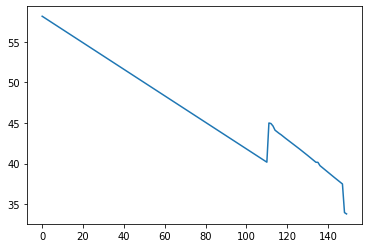

In [117]:
plt.plot(olg.L[0,:150])

In [ ]:
olg.evaluate_initial_state()

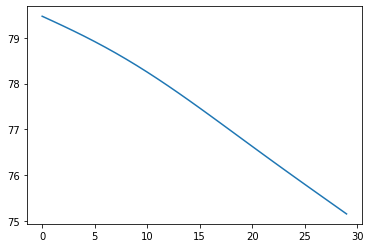

In [121]:
plt.plot(olg.Labor[120:150])

In [65]:
olg.lmbda_to_price[1,249]

1.348661539231219

In [68]:
t=249
0.5*np.array([olg.i[0,t+1],olg.k[0,t+2],olg.L_share[0,t+1],\
            olg.lmbda_to_price[0,t+1], olg.i[1,t+1],olg.k[1,t+2],\
            olg.lmbda_to_price[1,t+1],\
            olg.w[t+1], olg.price_N[t+1], olg.price[t+1]])+\
            0.5*np.array([olg.i[0,t],olg.k[0,t+1],olg.L_share[0,t],\
            olg.lmbda_to_price[0,t], olg.i[1,t],olg.k[1,t+1],\
            olg.lmbda_to_price[1,t],\
            olg.w[t], olg.price_N[t], olg.price[t]])

array([ 0.06861176,  3.16948031,  0.60866257,  1.26994532,  0.06861121,
        1.82370699,  1.28349722, 23.5044066 ,  0.97563833,  0.97005048])

In [82]:
olg.w[148]

8.582537239123752

In [83]:
olg.history[148]

[     fun: 1.3167890216468667e-17
     info: {'x': array([0.06937677, 3.20596418, 0.44381836, 1.44662514, 0.06937788,
        1.84428038, 1.52187372, 6.96987998, 0.81918051, 0.7612096 ]), 'g': array([], dtype=float64), 'obj_val': 1.3167890216468667e-17, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
     nfev: 10
      nit: 9
     njev: 11
   status: 0
  success: True
        x: array([0.06937677, 3.20596418, 0.44381836, 1.44662514, 0.06937788,
        1.84428038, 1.52187372, 6.96987998, 0.81918051, 0.7612096 ])]

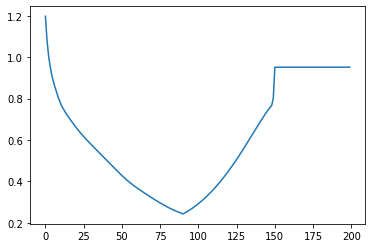

In [78]:
plt.plot(olg.Consumption[:200]/olg.Labor[:200]/olg.A[0,:200])

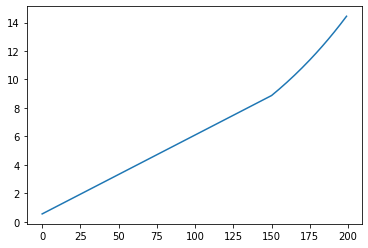

In [32]:
plt.plot(olg.w[:200])

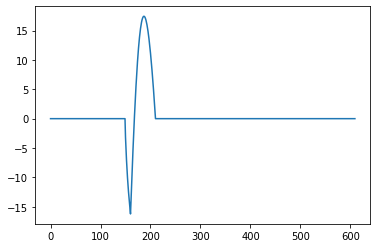

In [46]:
plt.plot(olg.a[0,:,150])

In [45]:
olg.household(0,150,100)

(1.9566893576706055, 0.7650662741534084, 11.769610295671846)

In [13]:
olg.create_guess()

In [3]:
olg.create_guess()

In [5]:
olg.update_guess()

TypeError: update_guess() missing 1 required positional argument: 't'

13.97038559398257
13.97038559398257
13.97038559398257
13.97038559398257


In [42]:
t=0
(1-olg.alpha)*1 *(olg.k[1, t]/(1-olg.L_share[0,t])*olg.A[0,t]/olg.A[1,t])**0.25* olg.A[1, t] 

0.5739835384774816

In [45]:
olg.Labor[0]

13.97038559398257

In [36]:
olg.k[1, t]

0.12039529431235176

In [38]:
(olg.k[1, t]/(1-olg.L_share[0,t]))**olg.alpha

0.8401958128048662

In [37]:
(olg.k[1, t]/(1-olg.L_share[0,t])*olg.A[0,t]/olg.A[1,t])**olg.alpha

0.8401958128048663

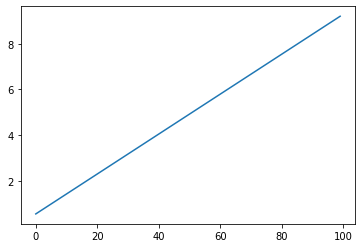

In [22]:
plt.plot(olg.w[0:100])

In [11]:
olg.Consumption[250:350]

array([ 556.42002429,  560.10190598,  563.808151  ,  567.53892059,
        571.29437701,  575.07468364,  578.88000489,  582.7105063 ,
        586.56635448,  590.44771716,  594.35476317,  598.28766245,
        602.24658609,  606.23170628,  610.24319637,  614.28123086,
        618.34598538,  622.43763676,  626.55636296,  630.70234314,
        634.87575766,  639.07678803,  643.305617  ,  647.56242852,
        651.84740774,  656.16074106,  660.5026161 ,  664.87322172,
        669.27274803,  673.7013864 ,  678.15932948,  682.64677116,
        687.16390666,  691.71093245,  696.28804632,  700.89544737,
        705.53333601,  710.20191398,  714.90138435,  719.63195154,
        724.39382133,  729.18720083,  734.01229857,  738.86932441,
        743.75848963,  748.6800069 ,  753.6340903 ,  758.62095531,
        763.64081886,  768.69389931,  773.78041644,  778.90059152,
        784.05464726,  789.24280785,  794.46529898,  799.7223478 ,
        805.01418298,  810.34103472,  815.70313472,  821.10071

In [13]:
810/805

1.0062111801242235

In [64]:
35.92413367/demography['N'][:,:,250].sum()# цель 0.65 

0.616574344522428

In [6]:
olg.evaluate_initial_state()

441.5391345933429
441.5391345933429
441.5391345933429
441.5391345933429


In [11]:
"k_N_steady", "L_N_share",
"k_E_steady", "w_steady",
"price_steady", "price_N_steady"

('price_steady', 'price_N_steady')

In [12]:
demography=np.load('demography.npy', allow_pickle=True).item()

0.8150489457014909

In [48]:
olg.create_guess()

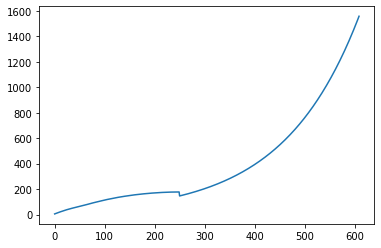

In [56]:
plt.plot(olg.w*olg.Labor*olg.tau_rho/(1+olg.tau_rho + olg.tau_Ins))

In [35]:
olg.VA_sum# + self.I_sum[t]+self.II_sum[t]+self.Ins_sum[t]+self.Rho_sum[t]+self.Pi_sum[t]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [23]:
olg.steady_state()
olg.steady_path[-1]

(     fun: 9.860698309180621e-17
     info: {'x': array([ 4.14947849,  0.82643216,  0.87147639, 22.42212501,  1.00000004,
         1.00000005]), 'g': array([], dtype=float64), 'obj_val': 9.860698309180621e-17, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0.]), 'status': 0, 'status_msg': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'}
  message: b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'
     nfev: 2
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([ 4.14947849,  0.82643216,  0.87147639, 22.42212501,  1.00000004,
         1.00000005]),
 array([ 4.14937873e+00,  8.26414768e-01,  8.71565246e-01,  2.24221394e+01,
         1.00000130e+00,  1.00000177e+00,  1.24402971e+03,  3.84706709e+01,
        -4.60350340e+04]))

In [22]:
for i in range(10):
    olg.steady_state()
    print(olg.steady_path[-1][0]['success'])

True
True
True
True
True
True
True
True
True
True


In [18]:
(2.61244168e+00/4.96977115e-01)**0.35*4.96977115e-01

0.888351756370893

In [27]:
(3.59554431e+02/2.38258337e+01/19+olg.i_steady*(2.61244168e+00+2.59784231e+00))*0.8

0.9174244994958803

In [12]:
olg.Gov[250]/olg.A[0,250]

369.55613492546206

In [94]:
olg.steady_path

[]

In [25]:
olg.create_guess()

4.514081065421861
4.49981883316465
4.485601662408552
4.471429410781825
4.457301936362546
4.443219097677199
4.429180753699247
4.415186763847732
4.401236987985858
4.3873312864195935
4.373469519896267
4.359651549603178
4.345877237166203
4.332146444648413
4.318459034548689
4.304814869800348
4.291213813769765
4.277655730255017
4.264140483484501
4.2506679381155905
4.237237959233273
4.223850412348797
4.210505163398333
4.197202078741618
4.183941025160635
4.170721869858261
4.15754448045695
4.144408724997401
4.131314471937237
4.118261590149692
4.1052499489222924
4.0922794179555515
4.079349867361662
4.0664611676632
4.053613189791823
4.04080580508698
4.028038885294622
4.015312302565922
4.002625929455987
3.9899796389225886
3.9773733043248867
3.9648067994221634
3.9522799983725583
3.939792775731808
3.927345006451989
3.9149365658802675
3.9025673297576517
3.890237174217743
3.8779459757855
3.865693611376
3.8534799582932084
3.841304894228746
3.829168297260669
3.8170700458522444
3.805010018850735
3.792988

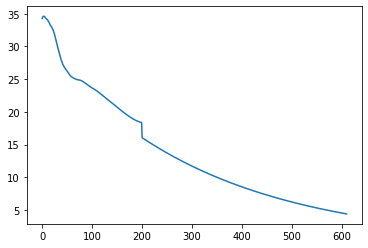

In [26]:
plt.plot(olg.Labor)

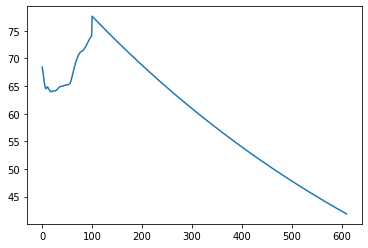

In [11]:
plt.plot(olg.Consumption)

In [52]:
tol = 10e-5
niter = 30

Ищем steady state

In [641]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _ in tqdm(range(niter),
                  desc = 'Steady state',
                      token=os.getenv('comp_bot_token'),
                      chat_id=os.getenv('chat_id')):
        olg.steady_state()
        if (len(olg.steady_path)>1) and \
            (max(abs(olg.steady_path[-1][1] - olg.steady_path[-2][1]))<tol):
            
                break
olg.update_a_initial()
olg.create_guess()

Steady state:   0%|          | 0/30 [00:00<?, ?it/s]

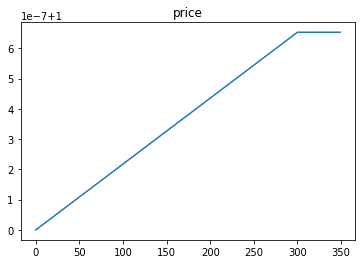

In [642]:
bot = TelegramBot(os.getenv('comp_bot_token'),
                      os.getenv('chat_id'))

plt.plot(olg.price[0:350])
plt.title("price")

bot.send_plot(plt)

# This method delete the generetad image
bot.clean_tmp_dir()

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

Steady state:   0%|          | 0/299 [00:00<?, ?it/s]

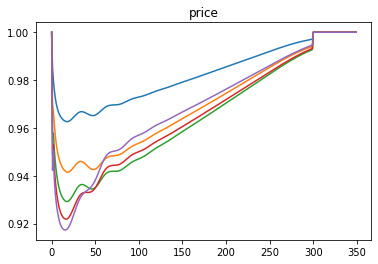

In [420]:
for i in range(5):
    for t in tqdm(reversed(range(1,olg.T)),
                      desc = f'path to steady {i}',
                      total=olg.T-1,
                          token=os.getenv('comp_bot_token'),
                          chat_id=os.getenv('chat_id')):
        olg.update_guess(t)
    plt.plot(olg.price[:(olg.T+50)])
    plt.title("price")

    bot.send_plot(plt)

    bot.clean_tmp_dir()

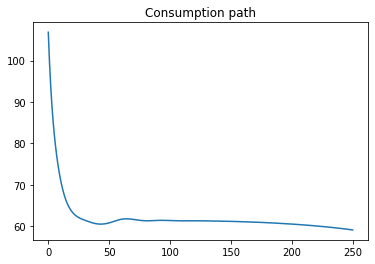

In [643]:
bot = TelegramBot(os.getenv('comp_bot_token'),
                      os.getenv('chat_id'))

plt.plot(olg.Consumption[:251])
plt.title("Consumption path")

bot.send_plot(plt)

# This method delete the generetad image
bot.clean_tmp_dir()

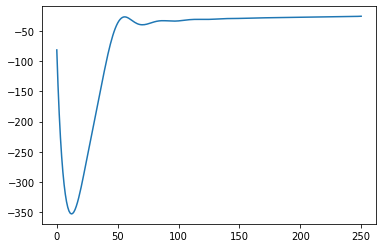

In [627]:
plt.plot(olg.Assets[:251])

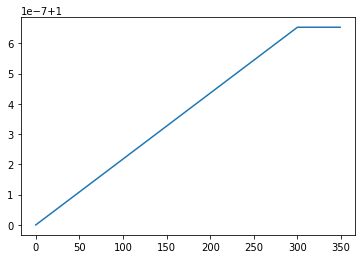

In [625]:
plt.plot(olg.price[:350])

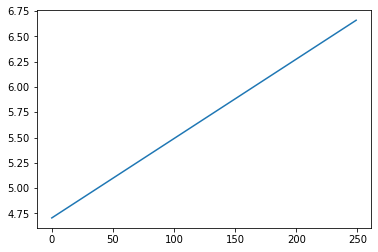

In [626]:
plt.plot(olg.k[0,:250])

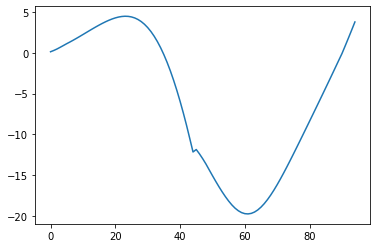

In [498]:
# plt.plot(olg.Pi[0,(45+olg.G-1):45:-1,45])
# plt.plot(olg.c[0,(45+olg.G-1):45:-1,45])
plt.plot(olg.a[0,(45+olg.G-1):45:-1,45])

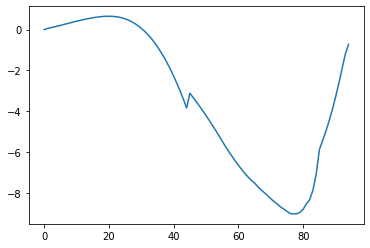

In [515]:
t=0
plt.plot(olg.a[0,(t+olg.G-1):t:-1,t])

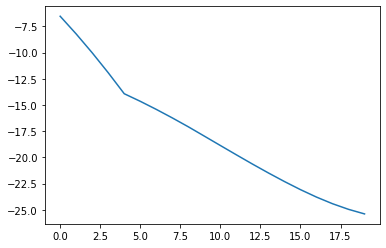

In [494]:
plt.plot(olg.a[0,250,155:251][40:60])
# plt.plot(olg.Pi[0,250,155:251])

In [ ]:
olg.c[0,90:110,45]

In [201]:
high_deficit = np.where(olg.Deficit_ratio[:(olg.T+1)]>0.2)[0]
if len(high_deficit) > 0:
    olg.sigma =np.concatenate((olg.sigma[:high_deficit[0]],
                           np.array([olg.sigma[high_deficit[0]]*0.9 
                                     for _ in range(high_deficit[0],max_time)])))
    if olg.T-olg.G + 1 < high_deficit[0]:
        olg.T = high_deficit[0] + olg.G - 1

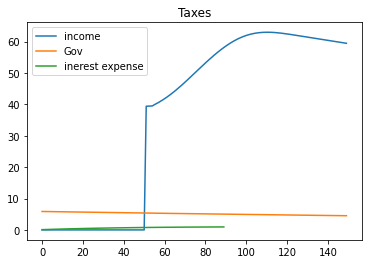

In [537]:
# plt.plot(olg.Gov_Income[200:250])
# Ins_sum  II_sum I_sum VA_sum Pi_sum
plt.plot(olg.Gov_Income[100:250], label = "income")
# plt.plot(olg.Ins_sum[160:250], label = "insurance")
# plt.plot(olg.II_sum[160:250], label = "investment income")
# plt.plot(olg.I_sum[160:250], label = "income")
# plt.plot(olg.VA_sum[160:250], label = "value-added")
# plt.plot(olg.Pi_sum[160:250], label = "profit")
plt.title("Taxes")
# plt.plot(olg.Gov_Outcome[0:250], label = "outcome")
plt.plot(olg.Gov[100:250], label = "Gov")
plt.plot(olg.Debt[160:250]*olg.r[160:250]/olg.Gov_Outcome[160:250], label = "inerest expense")
plt.legend()

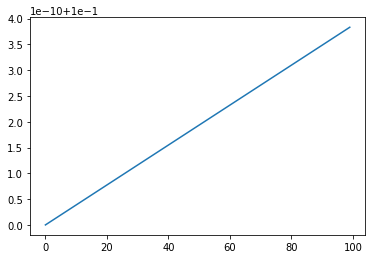

In [210]:
plt.plot(olg.price[:100])

In [214]:
olg.price[100]

0.10000000038709678

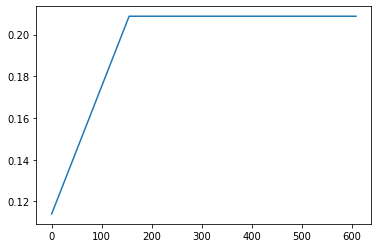

In [221]:
plt.plot(olg.w)

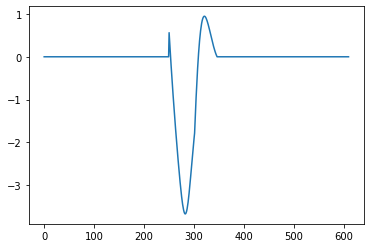

In [215]:
plt.plot(olg.a[0,:,250])

In [25]:
olg.create_guess()

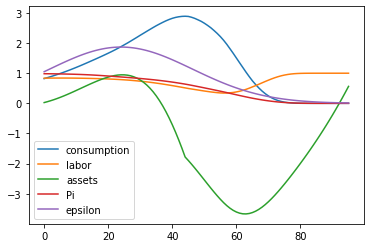

In [216]:
plt.plot(olg.c[0,345:249:-1,250], label = "consumption")
plt.plot(olg.l[0,345:249:-1,250], label = "labor")
plt.plot(olg.a[0,345:249:-1,250], label = "assets")
plt.plot(olg.Pi[0,345:249:-1,250], label = "Pi")
plt.plot(olg.epsilon[0,345:249:-1,250], label ="epsilon")
plt.legend()

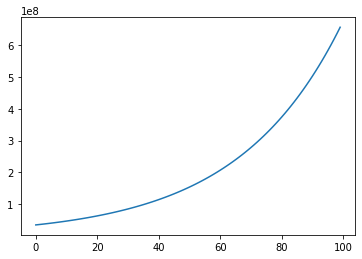

In [179]:
plt.plot(olg.Deficit[150:250])

Text(0.5, 1.0, 'wage adjustment')

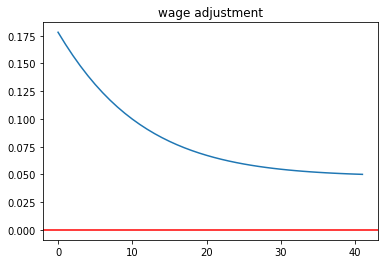

In [173]:
plt.plot([item[1][6] for i, item in enumerate(olg.steady_path)])
# plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.axhline(y=0, color='r', linestyle='-')
plt.title("wage adjustment")

Text(0.5, 1.0, 'Labor')

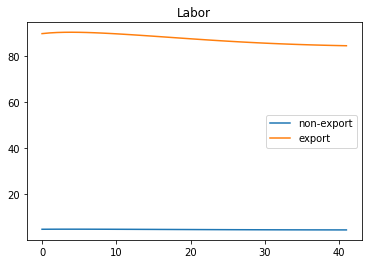

In [174]:
plt.plot([item[1][1]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([(1-item[1][1])*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Labor")

Text(0.5, 1.0, 'Capital')

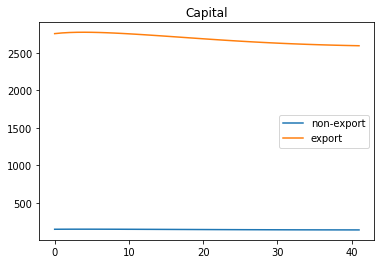

In [175]:
plt.plot([item[1][0]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([item[1][2]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Capital")

Text(0.5, 1.0, 'non-export labor share adjustment')

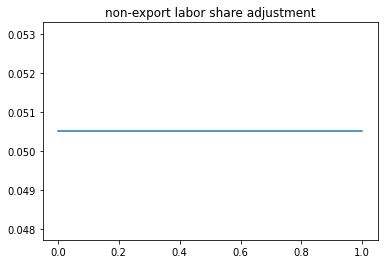

In [217]:
# plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)])
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.title("non-export labor share adjustment")

Text(0.5, 1.0, 'cons adjustment')

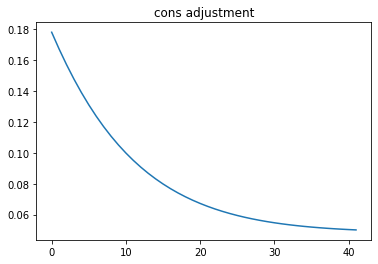

In [177]:
plt.plot([item[1][-3] for i, item in enumerate(olg.steady_path)])
plt.title("cons adjustment")

Text(0.5, 1.0, 'price adjustment')

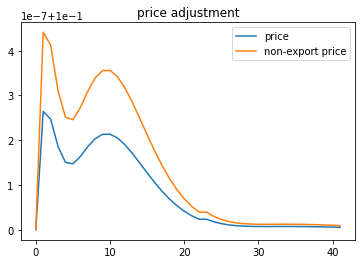

In [178]:
plt.plot([item[1][4] for i, item in enumerate(olg.steady_path)], label ="price")
plt.plot([item[1][5] for i, item in enumerate(olg.steady_path)], label ="non-export price")
plt.legend()
plt.title("price adjustment")

Text(0.5, 1.0, 'Target function')

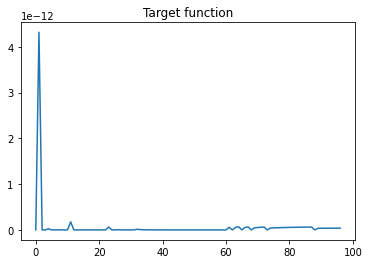

In [163]:
import matplotlib.pyplot as plt
plt.plot([item[0]["fun"] for i, item in enumerate(olg.steady_path)])
plt.title("Target function")

Text(0.5, 1.0, 'k')

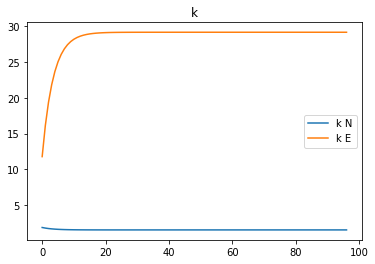

In [164]:
plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)], label ="k N")
plt.plot([item[1][2] for i, item in enumerate(olg.steady_path)], label ="k E")
plt.legend()
plt.title("k")

Text(0.5, 1.0, 'k non-export adjustment')

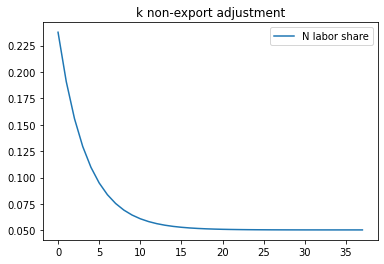

In [152]:
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)], label ="N labor share")
plt.legend()
plt.title("labor share")

In [279]:
olg.steady_path[-4]
# единственный выход это потребление тоже менять с eta

(     fun: 497133.5107400712
     info: {'x': array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]), 'g': array([], dtype=float64), 'obj_val': 497133.5107400712, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': -3, 'status_msg': b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'}
  message: b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'
     nfev: 629
      nit: 21
     njev: 25
   status: -3
  success: False
        x: array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]),
 array

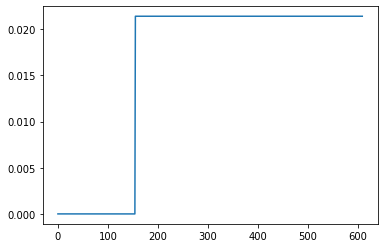

In [38]:
import matplotlib.pyplot as plt
plt.plot(olg.w)

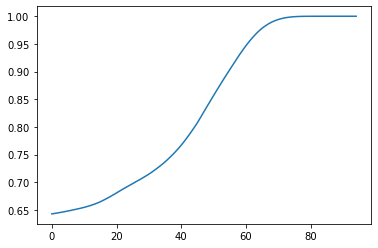

In [606]:
# plt.plot(olg.c[0][345-30,(250-30):(345-30)]) # труд у дрпугих неправильно рассчитывается?
# plt.plot(olg.l[0][345-30,(250-30):(345-30)])


In [43]:
olg.w[99]

1.3201810425347083e-05

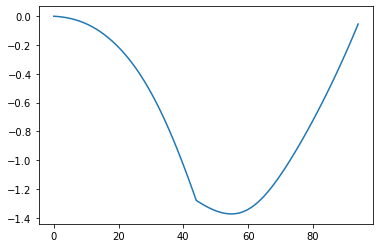

In [25]:
# plt.plot(olg.l[0][260,165:260], label= "labor")
# plt.plot(olg.c[0][260,165:260], label = "consumption")
plt.plot(olg.a[0][260,165:260], label = "assets")
# plt.plot((olg.c[0][260,165:260]**olg.phi * (1-olg.l[0][260,165:260])**(1-olg.phi))**(1-olg.theta)/(1-olg.theta), label = "utility")
plt.show()

Text(0.5, 1.0, 'Wage path')

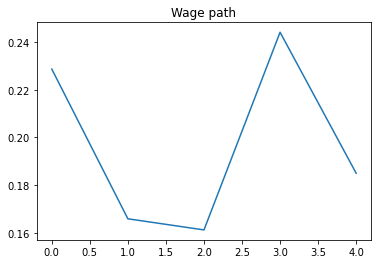

In [614]:
plt.plot([item[0]["info"]["x"][8] for i, item in enumerate(olg.steady_path)if i != 1] [0:])
plt.title("Wage path")

Text(0.5, 1.0, 'Price N path')

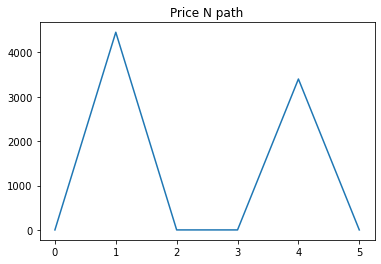

In [615]:
plt.plot([item[0]["info"]["x"][10] for item in olg.steady_path][0:])
plt.title("Price N path")

In [ ]:
import matplotlib.pyplot as plt
# plt.plot((((olg.c[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
# plt.plot((((olg.a[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
plt.plot((((olg.l[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:250])
# plt.plot(olg.I[0,:100]/olg.N[0].sum(axis=0)[:100])
# plt.plot((olg.l[0,:250]*olg.N[0,:250]).sum(axis=0)/(olg.N[0,:250].sum(axis=0)))
plt.show()

In [ ]:
plt.plot(olg.I[0,1:100]/olg.I[0,0:99])

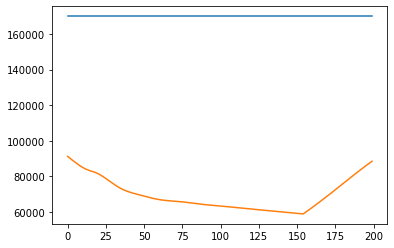

In [616]:
plt.plot(olg.L[0][:200]+olg.L[1][:200])
plt.plot(((olg.l[:,:610,:]*olg.N[:,:610,:]*olg.epsilon[:,:610,:]).sum(axis=0).sum(axis=0))[:200])

In [331]:
olg.L[0][:200]+olg.L[1][:200]

array([170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 1700

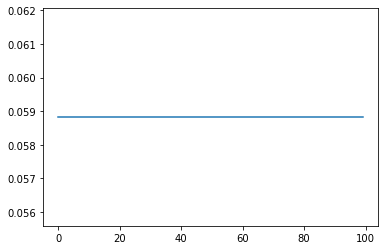

In [332]:
plt.plot((olg.K[0]/olg.L[0])[:100])

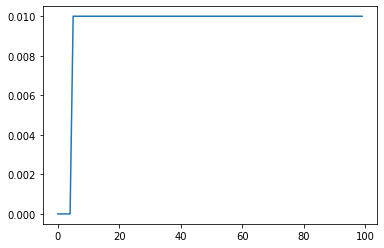

In [44]:
plt.plot(olg.a[0][100][:100])

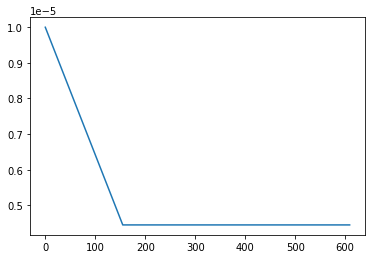

In [45]:
plt.plot(olg.price_N)

In [54]:
olg.w[120]

1.2925927310610548e-05

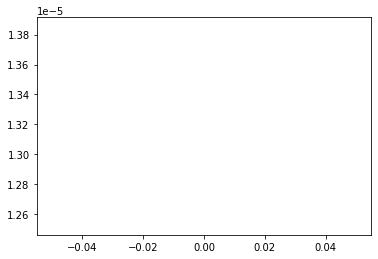

In [49]:
plt.plot(olg.w[100])